In [1]:
import pandas as pd

df = pd.read_csv('./data/clean/df_clean.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.reset_index(drop=True).sort_values(by='DATE')
df_snowlvl = df[['DATE', 'PRENEI_Q', 'PRELIQ_Q', 'T_Q', 'FF_Q', 'Q_Q',
       'DLI_Q', 'SSI_Q', 'HU_Q', 'EVAP_Q', 'ETP_Q', 'PE_Q', 'SWI_Q',
       'DRAINC_Q', 'RUNC_Q', 'RESR_NEIGE_Q', 'RESR_NEIGE6_Q', 'HTEURNEIGE_Q',
       'HTEURNEIGE6_Q', 'HTEURNEIGEX_Q', 'SNOW_FRAC_Q', 'ECOULEMENT_Q',
       'WG_RACINE_Q', 'WGI_RACINE_Q', 'TINF_H_Q', 'TSUP_H_Q']]

In [2]:
def transform_to_supervised(df, datetime_col, feature_cols, target_col, n_past=24, n_future=7):

    df = df.copy()
    df.sort_values(by=datetime_col, inplace=True)
    df.reset_index(drop=True, inplace=True)

    supervised = pd.DataFrame()

    for col in feature_cols:
        for i in range(n_past, 0, -1):
            supervised[f'{col}(t-{i})'] = df[col].shift(i)

    for i in range(0, n_future):
        supervised[f'{target_col}(t+{i})'] = df[target_col].shift(-i)

    supervised.dropna(inplace=True)

    return supervised

In [5]:
def compute_diff(df: pd.DataFrame) -> pd.DataFrame:
    
    return df.diff().dropna().reset_index(drop=True)

In [41]:
days_predict = 7

In [42]:
df_supervised = transform_to_supervised(df_snowlvl, 'DATE', ['HTEURNEIGE_Q'], 'HTEURNEIGE_Q', n_past=24, n_future=days_predict)

In [43]:
df_diff = compute_diff(df_supervised.copy())

In [44]:
X = df_diff.iloc[:,:-days_predict].copy()
y = df_diff.iloc[:,-days_predict:].copy()

In [45]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math

def train_forecast_per_step(X_train, X_test, y_train, y_test, df_supervised, split_idx):
    results = {}
    scaler_x = StandardScaler()

    # Scale inputs
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    for step in range(y_train.shape[1]):
        # Fit a separate scaler for each output step
        scaler_yi = StandardScaler()
        y_train_i_scaled = scaler_yi.fit_transform(y_train.iloc[:, step].values.reshape(-1, 1))
        y_test_i_scaled = scaler_yi.transform(y_test.iloc[:, step].values.reshape(-1, 1))

        # Train model for this step
        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        model.fit(X_train_scaled, y_train_i_scaled.ravel())

        # Predict
        yhat = model.predict(X_test_scaled)
        ytrue = y_test_i_scaled.ravel()

        # Evaluate
        rmse = math.sqrt(mean_squared_error(ytrue, yhat))
        print(f"Step {step} - RMSE (diff): {rmse:.4f}")

        # Plot predicted vs true (diff values)
        # plt.figure(figsize=(15, 3))
        # plt.plot(ytrue, label='True Δ')
        # plt.plot(yhat, label='Predicted Δ', alpha=0.7)
        # plt.title(f"Step {step} - Diff values")
        # plt.legend()
        # plt.show()

        # Reconstruct absolute values
        last_values = df_supervised.iloc[split_idx + 1:, -7].values.reshape(-1, 1)  # value(t-1)
        yhat_inv = scaler_yi.inverse_transform(yhat.reshape(-1, 1))
        ytrue_inv = scaler_yi.inverse_transform(ytrue.reshape(-1, 1))
        yhat_abs = last_values + yhat_inv
        ytrue_abs = last_values + ytrue_inv

        # Plot reconstructed absolute values
        # plt.figure(figsize=(15, 3))
        # plt.plot(ytrue_abs, label='True')
        # plt.plot(yhat_abs, label='Predicted', alpha=0.7)
        # plt.title(f"Step {step} - Reconstructed absolute values")
        # plt.legend()
        # plt.show()

        # Save results
        results[f"step_{step}"] = {
            "model": model,
            "scaler_y": scaler_yi,
            "rmse": rmse,
            "yhat_diff": yhat,
            "ytrue_diff": ytrue,
            "yhat_abs": yhat_abs,
            "ytrue_abs": ytrue_abs,
        }

    return results

In [68]:
results = train_forecast_per_step(X_train,X_test,y_train,y_test, df_supervised, split_idx=int(len(X)*0.8))

Step 0 - RMSE (diff): 0.6536
Step 1 - RMSE (diff): 0.6914
Step 2 - RMSE (diff): 0.6943
Step 3 - RMSE (diff): 0.6903
Step 4 - RMSE (diff): 0.6941
Step 5 - RMSE (diff): 0.6968
Step 6 - RMSE (diff): 0.6964


In [69]:
prediction = []
for step in results.keys():
    prediction.append(results[step]['yhat_abs'])
real = []
for step in results.keys():
    real.append(results[step]['ytrue_abs'])

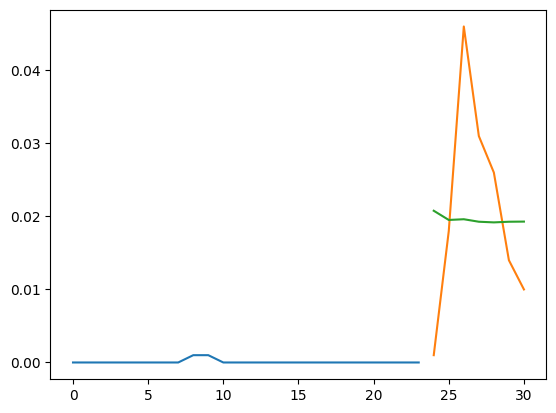

In [75]:
idx = 50
plt.plot(range(24), df_supervised.iloc[int(len(X)*0.8) + idx,:-days_predict])
plt.plot(range(24,24+days_predict), df_supervised.iloc[int(len(X)*0.8) + idx,-days_predict:])
plt.plot(range(24,24+days_predict), [pred[idx] for pred in prediction]);

In [55]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))
y_test_scaled = scaler_y.transform(pd.DataFrame(y_test))

# y_train_scaled = y_train.copy()
# y_test_scaled = y_test.copy()

In [54]:
import tensorflow as tf
from keras import layers, models, losses, optimizers

def build_probabilistic_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)

    mu = layers.Dense(1)(x)
    sigma = layers.Dense(1, activation='softplus')(x)  # softplus to ensure σ > 0

    outputs = layers.Concatenate()([mu, sigma])
    model = models.Model(inputs, outputs)
    return model

# Custom loss function for Gaussian NLL
def gaussian_nll(y_true, y_pred):
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1] + 1e-6  # avoid log(0)
    return tf.reduce_mean(0.5 * tf.math.log(2 * np.pi * sigma**2) + (y_true[:, 0] - mu)**2 / (2 * sigma**2))

In [56]:
model = build_probabilistic_model(input_dim=X_train.shape[1])
model.compile(optimizer='adam', loss=gaussian_nll)
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0)

In [57]:
mu_sigma_pred = model.predict(X_test_scaled)  # shape: (n_samples, 2)
mu_pred = mu_sigma_pred[:, 0]
sigma_pred = mu_sigma_pred[:, 1]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


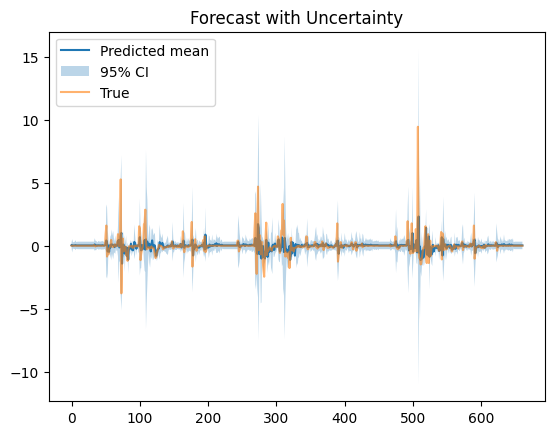

In [66]:
plt.plot(mu_pred, label='Predicted mean')
plt.fill_between(range(len(mu_pred)),
                 mu_pred - 1.96 * sigma_pred,
                 mu_pred + 1.96 * sigma_pred,
                 alpha=0.3, label='95% CI')
plt.plot(y_test_scaled[:,0], label='True', alpha=0.6)
plt.legend()
plt.title("Forecast with Uncertainty")
plt.show()


In [85]:
def train_one_probabilistic_step(X_train_scaled, y_train_step_scaled, 
                                 X_test_scaled, y_test_step_scaled, 
                                 df_supervised, split_idx, step, y_scaler):
    
    model = build_probabilistic_model(X_train_scaled.shape[1])
    model.compile(optimizer='adam', loss=gaussian_nll)
    model.fit(X_train_scaled, y_train_step_scaled, epochs=50, batch_size=32, verbose=0)

    y_pred = model.predict(X_test_scaled)
    mu_pred, sigma_pred = y_pred[:, 0], y_pred[:, 1]
    y_true = y_test_step_scaled.ravel()

    # Evaluate
    rmse = math.sqrt(mean_squared_error(y_true, mu_pred))
    print(f"Step {step} - RMSE (diff, μ): {rmse:.4f}")

    # Reconstruct absolute values
    last_values = df_supervised.iloc[split_idx + 1:, -25].values.reshape(-1, 1)
    
    mu_inv = y_scaler.inverse_transform(mu_pred.reshape(-1, 1))
    sigma_inv = sigma_pred.reshape(-1, 1) * y_scaler.scale_  # because σ is std, not mean
    ytrue_inv = y_scaler.inverse_transform(y_true.reshape(-1, 1))

    yhat_abs = last_values + mu_inv
    ytrue_abs = last_values + ytrue_inv

    return {
        "model": model,
        "rmse": rmse,
        "mu_diff": mu_pred,
        "sigma_diff": sigma_pred,
        "mu_abs": mu_inv,
        "sigma_abs": sigma_inv,
        "ytrue_diff": y_true,
        "yhat_abs": yhat_abs,
        "ytrue_abs": ytrue_abs,
    }

In [86]:
def train_forecast_per_step_probabilistic(X_train, X_test, y_train, y_test, df_supervised, split_idx):
    results = {}
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    for step in range(y_train.shape[1]):
        y_scaler = StandardScaler()
        y_train_step = y_train.iloc[:, step].values.reshape(-1, 1)
        y_test_step = y_test.iloc[:, step].values.reshape(-1, 1)
        y_train_scaled = y_scaler.fit_transform(y_train_step)
        y_test_scaled = y_scaler.transform(y_test_step)

        result = train_one_probabilistic_step(X_train_scaled, y_train_scaled,
                                              X_test_scaled, y_test_scaled,
                                              df_supervised, split_idx, step, y_scaler)
        result["scaler_y"] = y_scaler
        results[f"step_{step}"] = result

    return results

In [87]:
results = train_forecast_per_step_probabilistic(X_train, X_test, y_train, y_test, df_supervised, split_idx=int(len(X)*0.8))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Step 0 - RMSE (diff, μ): 0.6963
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Step 1 - RMSE (diff, μ): 0.6955
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Step 2 - RMSE (diff, μ): 0.6966
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Step 3 - RMSE (diff, μ): 0.6925
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Step 4 - RMSE (diff, μ): 0.6969
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Step 5 - RMSE (diff, μ): 0.6954
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Step 6 - RMSE (diff, μ): 0.6972


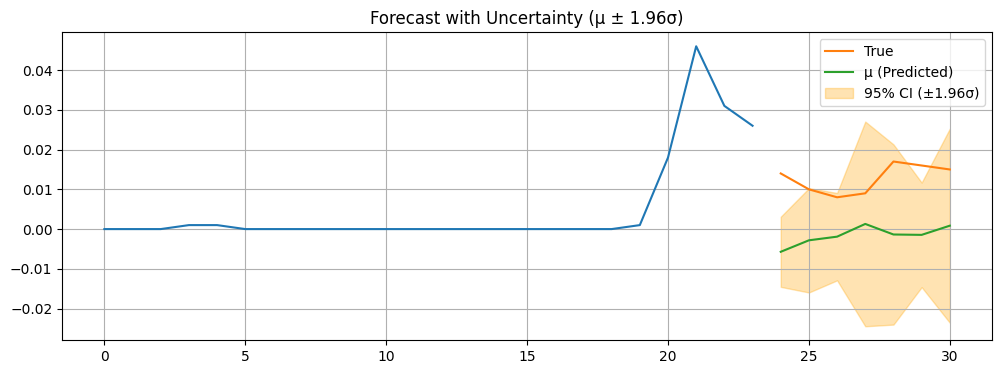

In [92]:
idx = 55
mu_forecast = np.array([results[f"step_{i}"]['mu_abs'][idx][0] for i in range(7)])
sigma_forecast = np.array([results[f"step_{i}"]['sigma_abs'][idx][0] for i in range(7)])
true_future = np.array([results[f"step_{i}"]['ytrue_abs'][idx][0] for i in range(7)])

plt.figure(figsize=(12, 4))

plt.plot(range(24), df_supervised.iloc[int(len(X)*0.8) + idx, :-7])
plt.plot(range(24, 31), df_supervised.iloc[int(len(X)*0.8) + idx, -7:], label='True')
plt.plot(range(24, 31), mu_forecast, label='μ (Predicted)')
plt.fill_between(range(24, 31),
                 mu_forecast - 1.96 * sigma_forecast,
                 mu_forecast + 1.96 * sigma_forecast,
                 color='orange', alpha=0.3, label='95% CI (±1.96σ)')
plt.legend()
plt.title("Forecast with Uncertainty (μ ± 1.96σ)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import math

def train_one_rf_probabilistic_step(X_train_scaled, y_train_step_scaled,
                                    X_test_scaled, y_test_step_scaled,
                                    df_supervised, split_idx, step, y_scaler):
    
    # Train mean model (μ)
    mu_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    mu_model.fit(X_train_scaled, y_train_step_scaled.ravel())
    mu_pred = mu_model.predict(X_test_scaled)
    y_true = y_test_step_scaled.ravel()
    
    # Train std model (σ): predict absolute error as proxy for std
    residuals_train = np.abs(y_train_step_scaled.ravel() - mu_model.predict(X_train_scaled))
    sigma_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    sigma_model.fit(X_train_scaled, residuals_train)
    sigma_pred = sigma_model.predict(X_test_scaled)

    # Evaluate
    rmse = math.sqrt(mean_squared_error(y_true, mu_pred))
    print(f"Step {step} - RMSE (diff, μ): {rmse:.4f}")

    # Reconstruct absolute values
    last_values = df_supervised.iloc[split_idx + 1:, -7].values.reshape(-1, 1)
    mu_inv = y_scaler.inverse_transform(mu_pred.reshape(-1, 1))
    sigma_inv = sigma_pred.reshape(-1, 1) * y_scaler.scale_  # propagate std scale
    ytrue_inv = y_scaler.inverse_transform(y_true.reshape(-1, 1))
    yhat_abs = last_values + mu_inv
    ytrue_abs = last_values + ytrue_inv

    return {
        "mu_model": mu_model,
        "sigma_model": sigma_model,
        "rmse": rmse,
        "mu_diff": mu_pred,
        "sigma_diff": sigma_pred,
        "mu_abs": mu_inv,
        "sigma_abs": sigma_inv,
        "ytrue_diff": y_true,
        "yhat_abs": yhat_abs,
        "ytrue_abs": ytrue_abs,
    }


In [105]:
def train_forecast_per_step_rf_probabilistic(X_train, X_test, y_train, y_test, df_supervised, split_idx):
    results = {}
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    for step in range(y_train.shape[1]):
        y_scaler = StandardScaler()
        y_train_step = y_train.iloc[:, step].values.reshape(-1, 1)
        y_test_step = y_test.iloc[:, step].values.reshape(-1, 1)
        y_train_scaled = y_scaler.fit_transform(y_train_step)
        y_test_scaled = y_scaler.transform(y_test_step)

        result = train_one_rf_probabilistic_step(X_train_scaled, y_train_scaled,
                                                 X_test_scaled, y_test_scaled,
                                                 df_supervised, split_idx, step, y_scaler)
        result["scaler_y"] = y_scaler
        results[f"step_{step}"] = result

    return results

In [ ]:
results = train_forecast_per_step_rf_probabilistic(X_train, X_test, y_train, y_test, df_supervised, split_idx=int(len(X)*0.8))


Step 0 - RMSE (diff, μ): 0.6679
Step 1 - RMSE (diff, μ): 0.7159
Step 2 - RMSE (diff, μ): 0.7214
Step 3 - RMSE (diff, μ): 0.7079
Step 4 - RMSE (diff, μ): 0.7142


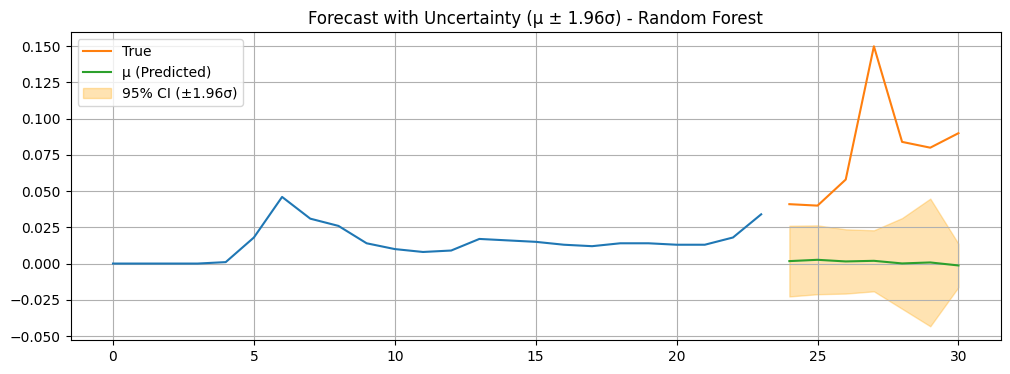

In [100]:
idx = 70
mu_forecast = np.array([results[f"step_{i}"]['mu_abs'][idx][0] for i in range(7)])
sigma_forecast = np.array([results[f"step_{i}"]['sigma_abs'][idx][0] for i in range(7)])
true_future = np.array([results[f"step_{i}"]['ytrue_abs'][idx][0] for i in range(7)])

plt.figure(figsize=(12, 4))
plt.plot(range(24), df_supervised.iloc[int(len(X)*0.8) + idx, :-7])
plt.plot(range(24, 31), df_supervised.iloc[int(len(X)*0.8) + idx, -7:], label='True')
plt.plot(range(24, 31), mu_forecast, label='μ (Predicted)')
plt.fill_between(range(24, 31),
                 mu_forecast - 1.96 * sigma_forecast,
                 mu_forecast + 1.96 * sigma_forecast,
                 color='orange', alpha=0.3, label='95% CI (±1.96σ)')
plt.legend()
plt.title("Forecast with Uncertainty (μ ± 1.96σ) - Random Forest")
plt.grid(True)
plt.show()
